This notebook explores the pop_synth and job_synth data 

In [1]:
import os 
os.environ['LD_LIBRARY_PATH'] = ':'.join([os.environ.get('LD_LIBRARY_PATH', ''), '/usr/local/cuda-9.0/lib64/'])
os.environ['PATH'] = ':'.join([os.environ.get('PATH', ''), '/usr/local/cuda-9.0/lib64/'])

In [1]:
### Importing the basic modules

#### First part: Analysis and data pre-processing
import os           # Working directory
import pandas as pd # Data processing
import matplotlib
import matplotlib.pyplot as plt # Common graphing interface (check also plotly and plotnine)

#### Second part: models and Hyperparameter optimization
import tensorflow as tf
import keras 
import numpy as np
from functools import partial

from keras.activations import relu, softmax 
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Activation, BatchNormalization, Concatenate, concatenate, Dense, Dropout, Input, InputLayer, Lambda, LeakyReLU
#from keras.layers.merge import _Merge
from keras.losses import mse, binary_crossentropy, categorical_crossentropy, mean_squared_error
import keras.metrics as metrics
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

#### Third part: model validation and graphs
import geopandas as gpd

# Bayesian optimization modules
#import GPy, GPyOpt

#### Extra
import random as rn

# Personal modules
from Utils import tuUtils
from Utils import validationUtils
from Utils import plotUtils
from Utils import validationGAN
from GAN.wganModel import WGAN

2023-12-21 00:46:02.192882: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 00:46:02.192929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 00:46:02.192972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 00:46:02.204086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Random number seeds
#np.random.seed(42) # Numpy
#rn.seed(12345) # Python
#tf.random.set_seed(1234) # TenforFlow

In [4]:
# prevent tensorflow from allocating the entire GPU memory at once
#from keras.backend.tensorflow_backend import set_session
#from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
#"""
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "0"
#session = tf.Session(config=config)
#"""
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2023-12-21 00:46:05.436022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 00:46:05.449546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 00:46:05.450105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
### Changing the working directory
#os.chdir('C:/Users/shgm/Desktop/projects/job_VAE') # PC
#os.chdir('/mnt/sdb1/data_shgm/') # Server 32
os.chdir('/home/s212945/snap/snapd-desktop-integration/current/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Data')
#print(os.getcwd())
#%cd ~/MasterThesis/MSc_PopSyn/Sigga_Luis/Data
#os.chdir('/Users/siggahalldorsdottir/Documents/THESIS/Code/MSc_PopSyn/Sigga_Luis/Data')

In [6]:
df_dtypes = {
    'CarModelYear': 'category',
    'Education': 'category',
    'FamNumAdults': 'int64',
    'FamNumPers': 'int64',
    'FuelType': 'category',
    'Gender': 'category',
    'Handicap': 'category',
    'HomeAdrZone': 'category',
    'HousehCarOwnership': 'category',
    'HousehNumAdults': 'int64',
    'HousehNumPers': 'int64',
    'HousehNumcars': 'int64',
    'HwDayspW': 'category',
    'IncFamily2000': 'int64',
    'IncRespondent2000': 'int64',
    'KidsBetween0and4': 'int64',
    'KidsBetween4and15': 'int64',
    'MunicipalityDest': 'category',
    'MunicipalityOrigin': 'category',
    'PopSocio': 'category',
    'PrimOccZone': 'category',
    'RespAgeCorrect': 'int64',
    'RespHasBicycle': 'category',
    'RespHasRejsekort': 'category',
    'RespIsmemCarshare': 'category',
    'RespPrimOcc': 'category',
    'ResphasDrivlic': 'category',
    'Sector': 'category',
    'WorkHourType': 'category',
    'WorkHoursPw': 'float64',
    'Year': 'category',
    'HomeParkPoss': 'category',
    'HousehAccomodation': 'category',
    'HousehAccOwnorRent': 'category',
    'PosInFamily': 'category',
    'PrimModeDay': 'category',
    'ModeChainTypeDay': 'category',
    'RespHasSeasonticket': 'category'
}

train = pd.read_csv('train.csv', sep=',', dtype=df_dtypes)
test = pd.read_csv('test.csv', sep=',', dtype=df_dtypes)

In [7]:
train.head()

Unnamed: 0 CarModelYear Education  FamNumAdults  FamNumPers FuelType  \
0       65076       2003.0       H10             4           6      1.0   
1        6178       2009.0       H10             3           6      1.0   
2       31893       2007.0       H60             2           2      2.0   
3       21387       1998.0       H60             1           1      1.0   
4       59643       2008.0       H30             2           7      2.0   

  Gender Handicap HomeAdrZone HousehCarOwnership  HousehNumAdults  \
0      1      2.0    846211.0                1.0                4   
1      1      2.0      1619.0                1.0                3   
2      1      2.0      3307.0                2.0                2   
3      2      2.0    751624.0                1.0                1   
4      1      2.0    630113.0                2.0                2   

   HousehNumPers  HousehNumcars HwDayspW  IncFamily2000  IncRespondent2000  \
0              6              1      5.0            356                149   
1              6              2      5.0              0                  0   
2              2              2      0.0            362                301   
3              1              1      0.0            286                286   
4              7              6      5.0            367                204   

   KidsBetween0and4  KidsBetween0and15 MunicipalityDest MunicipalityOrigin  \
0                 0                  1            730.0                846   
1                 1                  2            173.0                157   
2                 0                  0          MISSING                250   
3                 0                  0          MISSING                751   
4                 0                  3            630.0                630   

  PopSocio PrimOccZone  RespAgeCorrect RespHasBicycle RespHasRejsekort  \
0        0    730322.0              22            1.0              6.0   
1        0      2215.0              12            1.0             10.0   
2        3     MISSING              75            1.0              1.0   
3        3     MISSING              82            2.0             30.0   
4        1    630113.0              41            1.0             35.0   

  RespIsmemCarshare RespPrimOcc ResphasDrivlic  \
0               2.0       116.0            1.0   
1               2.0       107.0          -18.0   
2               2.0       370.0            1.0   
3               2.0       370.0            1.0   
4               2.0       221.0            1.0   

                                      Sector WorkHourType  WorkHoursPw  Year  
0                           Residential care  Not working          0.0  2010  
1                                  Education  Not working          0.0  2011  
2                        Activity not stated  Not working          0.0  2018  
3                        Activity not stated  Not working          0.0  2010  
4  Accommodation and food service activities      MISSING         40.0  2010

In [8]:
train.drop(train.columns[train.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
test.drop(test.columns[test.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

In [9]:
train.head()

CarModelYear Education  FamNumAdults  FamNumPers FuelType Gender Handicap  \
0       2003.0       H10             4           6      1.0      1      2.0   
1       2009.0       H10             3           6      1.0      1      2.0   
2       2007.0       H60             2           2      2.0      1      2.0   
3       1998.0       H60             1           1      1.0      2      2.0   
4       2008.0       H30             2           7      2.0      1      2.0   

  HomeAdrZone HousehCarOwnership  HousehNumAdults  HousehNumPers  \
0    846211.0                1.0                4              6   
1      1619.0                1.0                3              6   
2      3307.0                2.0                2              2   
3    751624.0                1.0                1              1   
4    630113.0                2.0                2              7   

   HousehNumcars HwDayspW  IncFamily2000  IncRespondent2000  KidsBetween0and4  \
0              1      5.0            356                149                 0   
1              2      5.0              0                  0                 1   
2              2      0.0            362                301                 0   
3              1      0.0            286                286                 0   
4              6      5.0            367                204                 0   

   KidsBetween0and15 MunicipalityDest MunicipalityOrigin PopSocio PrimOccZone  \
0                  1            730.0                846        0    730322.0   
1                  2            173.0                157        0      2215.0   
2                  0          MISSING                250        3     MISSING   
3                  0          MISSING                751        3     MISSING   
4                  3            630.0                630        1    630113.0   

   RespAgeCorrect RespHasBicycle RespHasRejsekort RespIsmemCarshare  \
0              22            1.0              6.0               2.0   
1              12            1.0             10.0               2.0   
2              75            1.0              1.0               2.0   
3              82            2.0             30.0               2.0   
4              41            1.0             35.0               2.0   

  RespPrimOcc ResphasDrivlic                                     Sector  \
0       116.0            1.0                           Residential care   
1       107.0          -18.0                                  Education   
2       370.0            1.0                        Activity not stated   
3       370.0            1.0                        Activity not stated   
4       221.0            1.0  Accommodation and food service activities   

  WorkHourType  WorkHoursPw  Year  
0  Not working          0.0  2010  
1  Not working          0.0  2011  
2  Not working          0.0  2018  
3  Not working          0.0  2010  
4      MISSING         40.0  2010

In [10]:
#samp_df.drop(columns=['HomeAdrZone', 'PrimOccZone'], inplace=True)

In [11]:
# Define age bins and corresponding categories
#bins = [0., 25., 50., 75., 100., 125., 150., 175., 200., 225., 250., 300., 350., 400., 450., 500., 80000.]
#cats = ['Under 25,000 DKK', '25,000 - 49,999 DKK', '50,000 - 74,999 DKK',
#       '75,000 - 99,999 DKK', '100,000 - 124,999 DKK',
#       '125,000 - 149,999 DKK', '150,000 - 174,999 DKK',
#       '175,000 - 199,999 DKK', '200,000 - 224,999 DKK',
#       '225,000 - 249,999 DKK', '250,000 - 299,999 DKK',
#       '300,000 - 349,999 DKK', '350,000 - 399,999 DKK',
#       '400,000 - 449,999 DKK', '450,000 - 499,999 DKK',
#       '500,000 DKK and more']

# Create a categorical variable 'AgeGroup' based on 'RespAgeCorrect' using the specified bins and labels
#samp_df['IncRespondent2000'] = pd.cut(samp_df['IncRespondent2000'], bins, labels=cats, right=False, include_lowest=True)

In [12]:
samp_df = train.copy()

In [13]:
#samp_df.drop(['SessionId', 'RespAgeCorrect'], axis=1, inplace=True)

# Definition of global lists for numerical and categorical variables. These will be used for pre processing and estimation
# Numerical and Categorical variable definitions 
numerical = ['IncFamily2000', 'IncRespondent2000', 'WorkHoursPw', 
             'FamNumAdults', 'FamNumPers', 'HousehNumAdults', 'HousehNumcars', 
             'HousehNumPers', 'RespAgeCorrect']

numerical_col_n = len(numerical) # Number of numerical variable

categorical = [col for col in list(samp_df) if col not in numerical]
samp_df[categorical] = samp_df[categorical].astype('category')

samp_df = samp_df[numerical + categorical]

categorical = [col for col in list(samp_df) if col not in numerical]
samp_df[categorical] = samp_df[categorical].astype('category')
categorical_col_n = len(categorical) # Number of categorical variables
categories_n = [] # Number of categories in each categorical variable
for cat in categorical:
    categories_n.append(len(samp_df[cat].cat.categories)) 
categories_cum = list(np.cumsum(categories_n)) # Cumulative sum of number of categorical variables
categories_cum = [x for x in categories_cum] # We take one out because they will be indexes
categories_cum = [0] + categories_cum

# Sort the dataset columns
samp_df = samp_df.reindex(numerical+categorical, axis=1)

#BINNING=False
#train, test, validation, pre_one_hot_df, one_hot_df, col_names, scaler = tuUtils.data_creator(samp_df, numerical=numerical, train_prop=0.812, val_prop=0.25, binning=BINNING, condition_on=None) # , quantiles=5 if dim too big

#n_inputs = train.shape[1]

train_set, pre_one_hot_df, one_hot_df, col_names, scaler = tuUtils.data_creator_noSplitting(samp_df, numerical)

Index(['IncFamily2000', 'IncRespondent2000', 'WorkHoursPw', 'FamNumAdults',
       'FamNumPers', 'HousehNumAdults', 'HousehNumcars', 'HousehNumPers',
       'RespAgeCorrect', 'CarModelYear_-1.0',
       ...
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Year_2016',
       'Year_2017', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021'],
      dtype='object', length=13172)
Train shape is: (97895, 13172)


In [14]:
train.head()

CarModelYear Education  FamNumAdults  FamNumPers FuelType Gender Handicap  \
0       2003.0       H10             4           6      1.0      1      2.0   
1       2009.0       H10             3           6      1.0      1      2.0   
2       2007.0       H60             2           2      2.0      1      2.0   
3       1998.0       H60             1           1      1.0      2      2.0   
4       2008.0       H30             2           7      2.0      1      2.0   

  HomeAdrZone HousehCarOwnership  HousehNumAdults  HousehNumPers  \
0    846211.0                1.0                4              6   
1      1619.0                1.0                3              6   
2      3307.0                2.0                2              2   
3    751624.0                1.0                1              1   
4    630113.0                2.0                2              7   

   HousehNumcars HwDayspW  IncFamily2000  IncRespondent2000  KidsBetween0and4  \
0              1      5.0            356                149                 0   
1              2      5.0              0                  0                 1   
2              2      0.0            362                301                 0   
3              1      0.0            286                286                 0   
4              6      5.0            367                204                 0   

   KidsBetween0and15 MunicipalityDest MunicipalityOrigin PopSocio PrimOccZone  \
0                  1            730.0                846        0    730322.0   
1                  2            173.0                157        0      2215.0   
2                  0          MISSING                250        3     MISSING   
3                  0          MISSING                751        3     MISSING   
4                  3            630.0                630        1    630113.0   

   RespAgeCorrect RespHasBicycle RespHasRejsekort RespIsmemCarshare  \
0              22            1.0              6.0               2.0   
1              12            1.0             10.0               2.0   
2              75            1.0              1.0               2.0   
3              82            2.0             30.0               2.0   
4              41            1.0             35.0               2.0   

  RespPrimOcc ResphasDrivlic                                     Sector  \
0       116.0            1.0                           Residential care   
1       107.0          -18.0                                  Education   
2       370.0            1.0                        Activity not stated   
3       370.0            1.0                        Activity not stated   
4       221.0            1.0  Accommodation and food service activities   

  WorkHourType  WorkHoursPw  Year  
0  Not working          0.0  2010  
1  Not working          0.0  2011  
2  Not working          0.0  2018  
3  Not working          0.0  2010  
4      MISSING         40.0  2010

In [15]:
samp_df['Gender'].head()

0    1
1    1
2    1
3    2
4    1
Name: Gender, dtype: category
Categories (2, object): ['1', '2']

In [16]:
#assert  all(val<100 for (n, val) in enumerate(categories_n))
for i in zip(categorical, categories_n):
    print(i)

('CarModelYear', 74)
('Education', 8)
('FuelType', 7)
('Gender', 2)
('Handicap', 2)
('HomeAdrZone', 6865)
('HousehCarOwnership', 13)
('HwDayspW', 8)
('KidsBetween0and4', 4)
('KidsBetween0and15', 9)
('MunicipalityDest', 100)
('MunicipalityOrigin', 99)
('PopSocio', 4)
('PrimOccZone', 5876)
('RespHasBicycle', 2)
('RespHasRejsekort', 10)
('RespIsmemCarshare', 2)
('RespPrimOcc', 18)
('ResphasDrivlic', 4)
('Sector', 37)
('WorkHourType', 6)
('Year', 13)


In [17]:
train_set = np.array(train_set)

/tmp/ipykernel_1619836/2806676414.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  train_set = np.array(train_set)


# WGAN main

In [18]:
epochs_WGAN = 10000
wgan_latent_dim = 150
_WGAN = WGAN(train=train_set, validation=test, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=1024, latent_dim=wgan_latent_dim, n_hidden_layers_gen=5, # Generator architecture 
             intermediate_dim_crit=1024, n_hidden_layers_crit=1, # Critic architecture 
             batch_size=512, epochs=epochs_WGAN, gen_learn_rate=3.29010632e-04 ,
             crit_learn_rate=3.29010632e-04 , clip_value=0.01, nCritic=5)#, drop_rate_g=0., drop_rate_c=0.10) # drop_rate_g=0., drop_rate_c=0.25
_WGAN.wgan_evaluate()

2023-12-21 00:46:35.998548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 00:46:35.999031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 00:46:35.999351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

16/16 [==============================] - 0s 2ms/step


2023-12-21 00:46:37.145140: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-21 00:46:37.957241: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f98a64140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 00:46:37.957264: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-21 00:46:37.957269: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-21 00:46:37.960799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-21 00:46:37.971109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-21 00:46:38.042402: I ./tensorflow/comp

16/16 [==============================] - 0s 2ms/step
0 [D loss: -0.244422, acc.: 0.00%] [G loss: 0.424742]
16/16 [==============================] - 0s 2ms/step
100 [D loss: -0.024426, acc.: 0.00%] [G loss: -0.005524]
16/16 [==============================] - 0s 3ms/step
200 [D loss: -0.019504, acc.: 0.00%] [G loss: -0.003585]
16/16 [==============================] - 0s 2ms/step
300 [D loss: -0.022729, acc.: 0.00%] [G loss: -0.004615]
16/16 [==============================] - 0s 2ms/step
400 [D loss: -0.023183, acc.: 0.00%] [G loss: 0.001247]
16/16 [==============================] - 0s 2ms/step
500 [D loss: -0.018872, acc.: 0.00%] [G loss: -0.002394]
16/16 [==============================] - 0s 2ms/step
600 [D loss: -0.021194, acc.: 0.00%] [G loss: -0.001881]
16/16 [==============================] - 0s 2ms/step
700 [D loss: -0.019454, acc.: 0.00%] [G loss: -0.001856]
16/16 [==============================] - 0s 9ms/step
800 [D loss: -0.020351, acc.: 0.00%] [G loss: -0.002158]
16/16 [=======

0.0006520051499722528

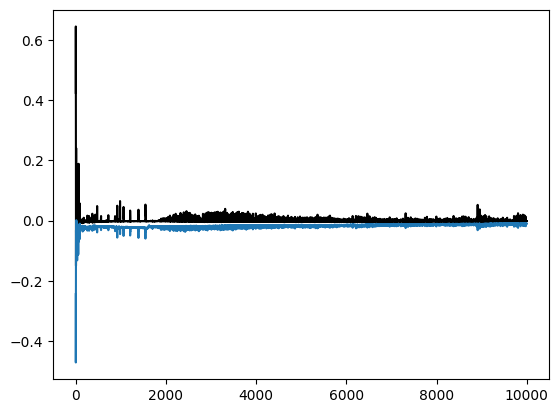

In [19]:
plt.plot(range(epochs_WGAN), _WGAN.gen_loss, 'k', range(epochs_WGAN), _WGAN.crit_loss);

In [20]:
_WGAN.n_samples = len(test)
wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)
wgan_n.head()

1304/1304 [==============================] - 4s 3ms/step


CarModelYear Education FuelType Gender Handicap HomeAdrZone  \
0         -1.0       H60    NoCar      1      2.0      4056.0   
1       1999.0       H10      1.0      1      2.0    330141.0   
2       2012.0       H10      1.0      2      1.0      1088.0   
3       2004.0       H10      1.0      2      1.0    760124.0   
4       2001.0       H60      1.0      1      2.0    851353.0   

  HousehCarOwnership HwDayspW KidsBetween0and4 KidsBetween0and15  \
0                0.0      5.0                0                 1   
1                0.0      0.0                0                 1   
2                1.0      5.0                0                 0   
3                1.0      0.0                0                 0   
4                1.0      0.0                0                 0   

  MunicipalityDest MunicipalityOrigin PopSocio PrimOccZone RespHasBicycle  \
0            101.0                101        1    621133.0            1.0   
1          MISSING                787        3     MISSING            2.0   
2            101.0                101        0      3789.0            2.0   
3          MISSING                430        3     MISSING            2.0   
4          MISSING                461        0     MISSING            2.0   

  RespHasRejsekort RespIsmemCarshare RespPrimOcc ResphasDrivlic  \
0              2.0               2.0       210.0            1.0   
1             30.0               2.0       350.0            1.0   
2              1.0               1.0       107.0          -18.0   
3              5.0               2.0       370.0            1.0   
4             35.0               2.0       370.0            1.0   

                                          Sector WorkHourType  Year  \
0  Publishing, television and radio broadcasting          4.0  2009   
1                            Activity not stated  Not working  2014   
2                                      Education  Not working  2018   
3                            Activity not stated  Not working  2012   
4                            Activity not stated  Not working  2011   

   IncFamily2000  IncRespondent2000  WorkHoursPw  FamNumAdults  FamNumPers  \
0       1.578673           1.587529     1.329333     -0.500154   -0.359592   
1      -0.721760          -0.436914    -0.800807      0.093115   -0.362016   
2      -1.309528          -1.883557    -1.063587      0.244947    0.756710   
3      -0.856973          -0.436266    -0.307231     -0.204508   -0.578017   
4      -0.725120          -0.283021    -1.127511     -1.454380   -0.634757   

   HousehNumAdults  HousehNumcars  HousehNumPers  RespAgeCorrect  
0        -0.206850      -1.159932      -0.013314       -0.121512  
1         0.128091      -0.132650       0.094607       -0.267252  
2         0.581794       0.090250       1.276777       -1.633420  
3        -0.112760      -0.186266      -0.677910        1.308075  
4        -1.084536      -0.384337      -0.780337       -0.149075

In [ ]:
_WGAN.n_samples = len(test)
wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, numerical=numerical, scaler=scaler, binning=False)
wgan_n.head()

Aggregated variables: 
MunicipalityOrigin
Number of combinations: 99
corr = 0.885350
MAE = 0.004939
RMSE = 0.010249
SRMSE = 1.004355
r2 = 0.059255


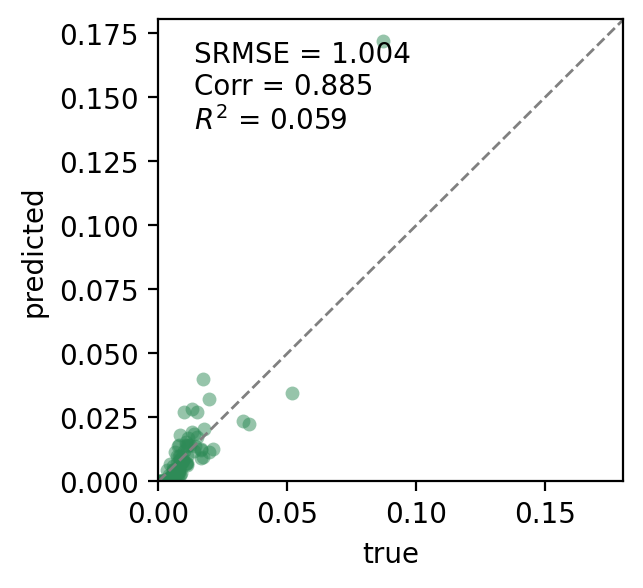

Aggregated variables: 
ResphasDrivlic
Number of combinations: 4
corr = 0.999902
MAE = 0.005105
RMSE = 0.005123
SRMSE = 0.020493
r2 = 0.999666


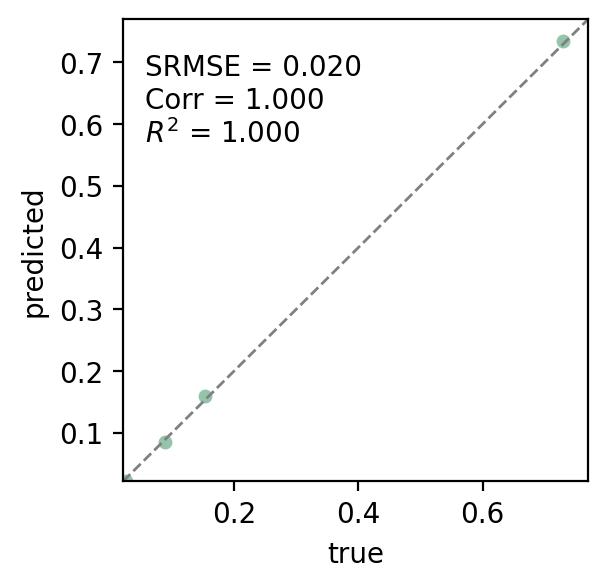

Aggregated variables: 
PopSocio
Number of combinations: 4
corr = 0.996163
MAE = 0.012427
RMSE = 0.014496
SRMSE = 0.057984
r2 = 0.990963


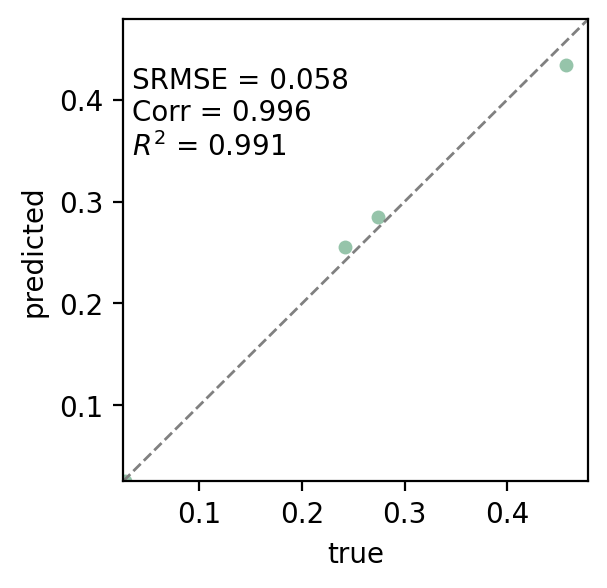

Aggregated variables: 
MunicipalityOrigin
ResphasDrivlic
Number of combinations: 396
corr = 0.867593
MAE = 0.001512
RMSE = 0.003666
SRMSE = 1.429792
r2 = 0.401547


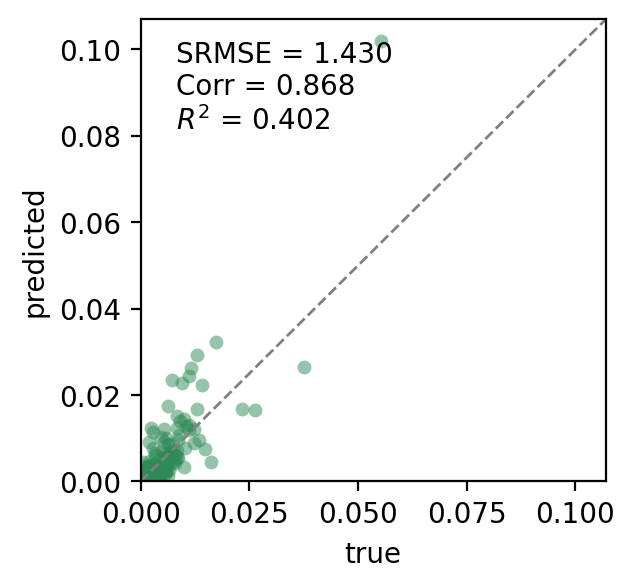

Aggregated variables: 
MunicipalityOrigin
ResphasDrivlic
PopSocio
Number of combinations: 1584
corr = 0.815442
MAE = 0.000638
RMSE = 0.001662
SRMSE = 1.879740
r2 = 0.250779


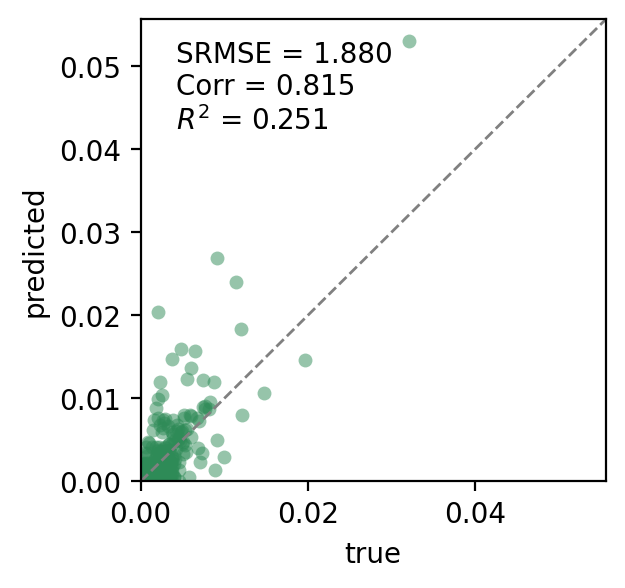

Aggregated variables: 
MunicipalityOrigin
ResphasDrivlic
PopSocio
Gender
Number of combinations: 3168
corr = 0.792205
MAE = 0.000376
RMSE = 0.000946
SRMSE = 1.932463
r2 = 0.114026


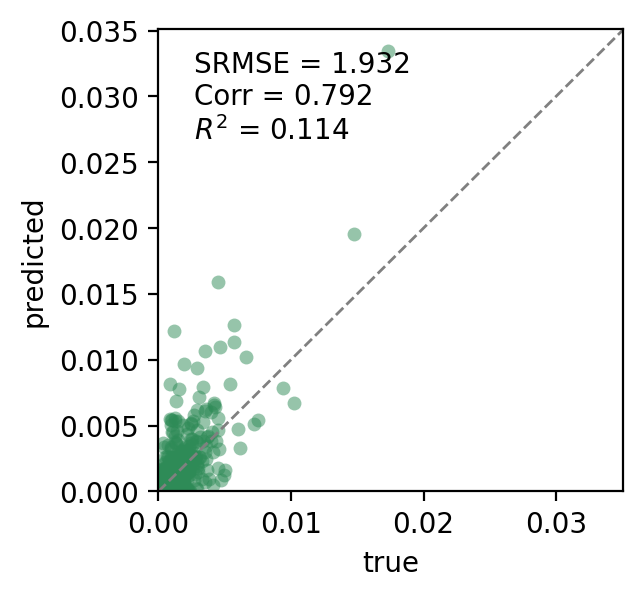

Aggregated variables: 
HomeAdrZone
Number of combinations: 6865
corr = 0.188932
MAE = 0.000273
RMSE = 0.001588
SRMSE = 10.041298
r2 = -115.548295


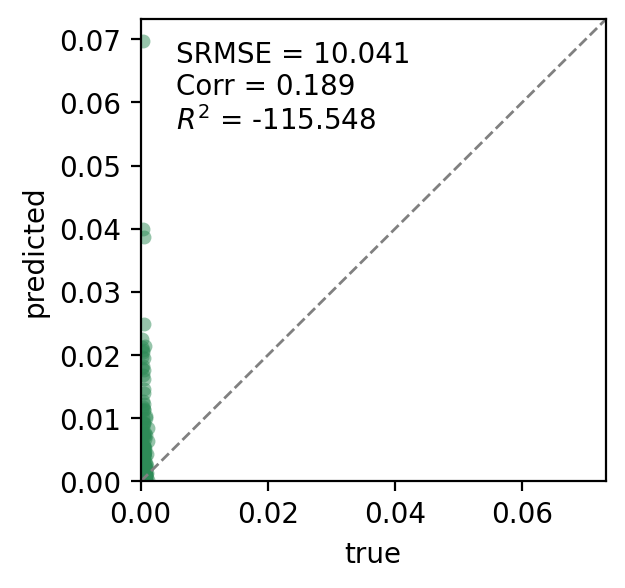

Aggregated variables: 
Education
Number of combinations: 8
corr = 0.997491
MAE = 0.015297
RMSE = 0.018193
SRMSE = 0.145542
r2 = 0.974767


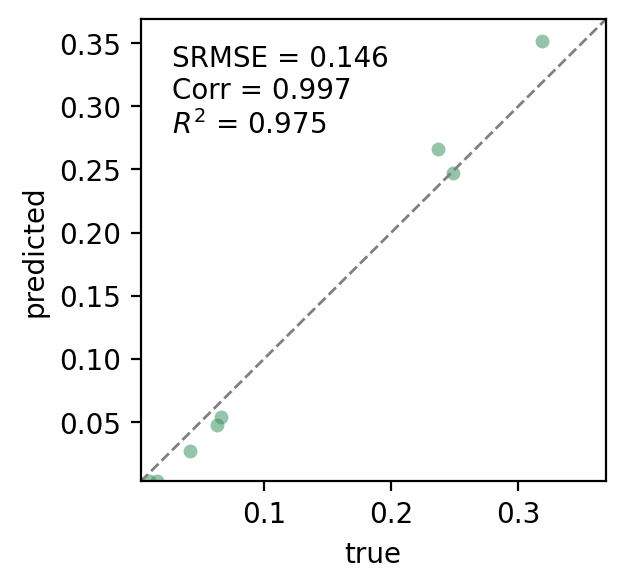

Aggregated variables: 
Sector
Number of combinations: 37
corr = 0.997938
MAE = 0.005524
RMSE = 0.012359
SRMSE = 0.457277
r2 = 0.961161


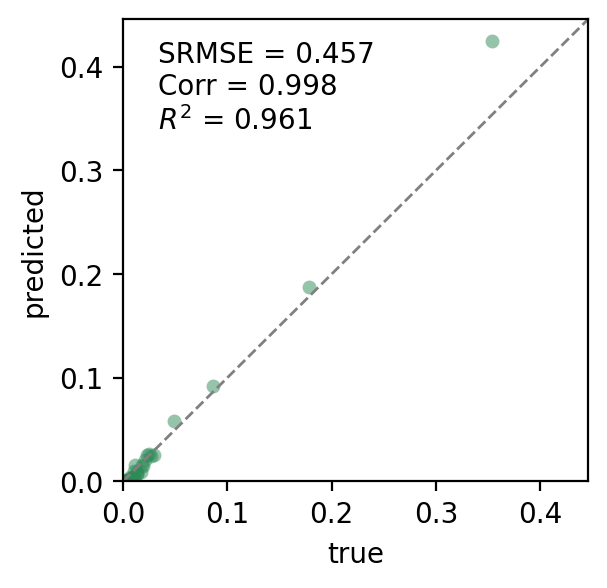

Aggregated variables: 
Education
Sector
Number of combinations: 296
corr = 0.986724
MAE = 0.001160
RMSE = 0.003648
SRMSE = 0.985019
r2 = 0.923867


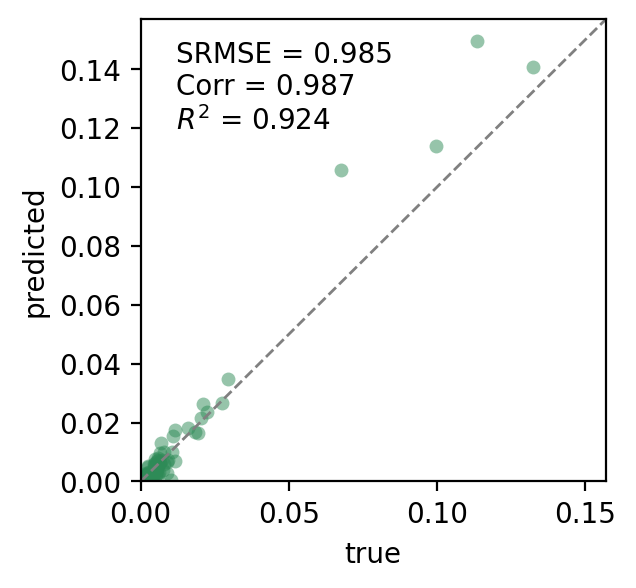

Aggregated variables: 
Education
Sector
Gender
Number of combinations: 592
corr = 0.983848
MAE = 0.000679
RMSE = 0.001986
SRMSE = 0.981327
r2 = 0.920979


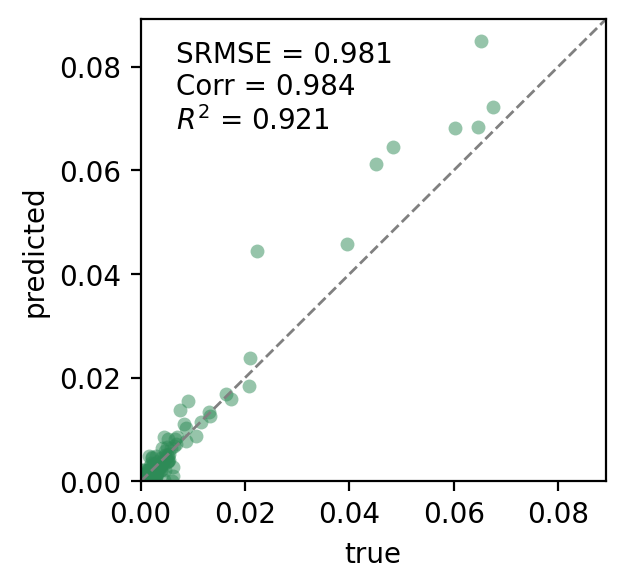

: 

In [54]:
validationGAN.validate_Gan_Cat(wgan_n, test,train)

Variable: IncFamily2000
TtestResult(statistic=-1.5659073476772425, pvalue=0.11737410137530657, df=83446.0)


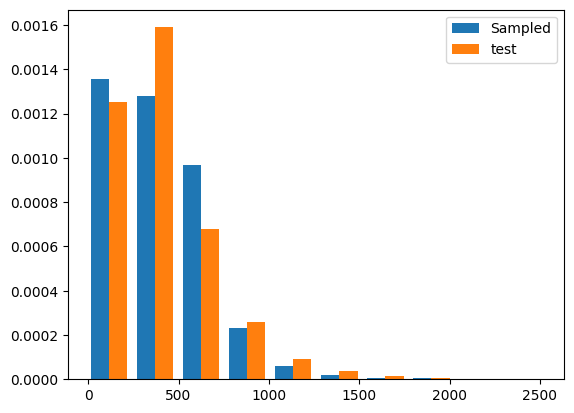

Variable: IncRespondent2000
TtestResult(statistic=10.712923975854537, pvalue=9.214360115162305e-27, df=83446.0)


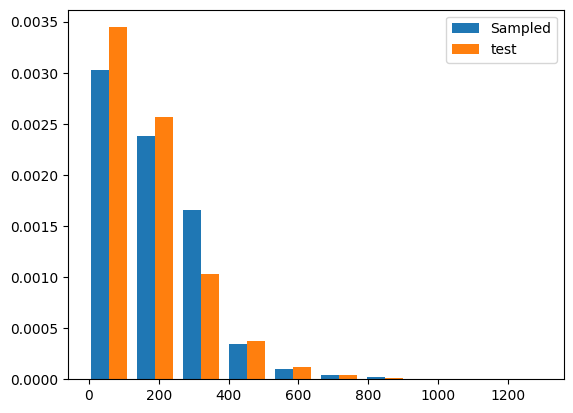

Variable: WorkHoursPw
TtestResult(statistic=-2.8944678845779768, pvalue=0.003799001448770299, df=83446.0)


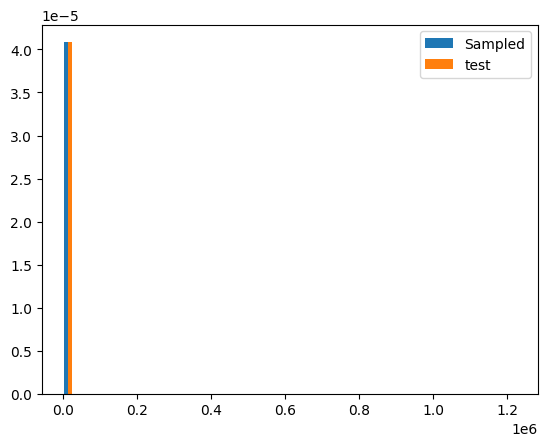

Variable: FamNumAdults
TtestResult(statistic=0.8109196098119499, pvalue=0.4174141508836996, df=83446.0)


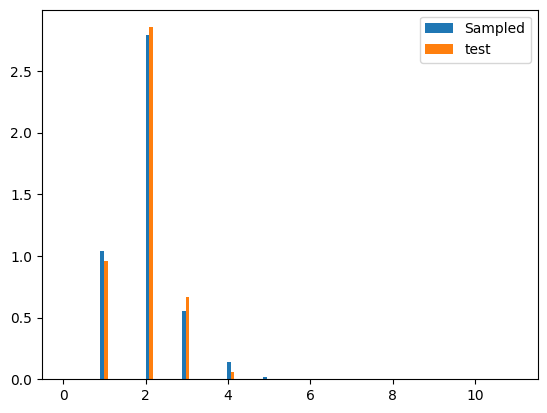

Variable: FamNumPers
TtestResult(statistic=-6.453668223503164, pvalue=1.0977047460842328e-10, df=83446.0)


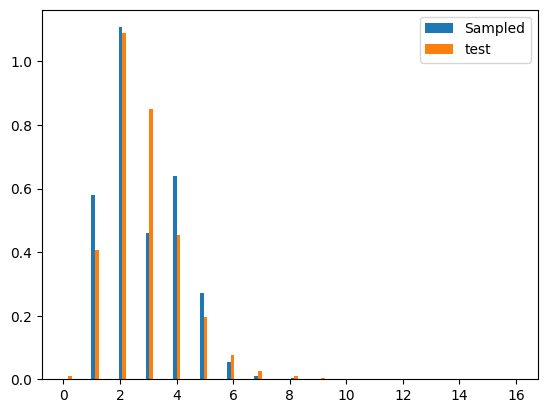

Variable: HousehNumAdults
TtestResult(statistic=-4.17048157614473, pvalue=3.0426328276345783e-05, df=83446.0)


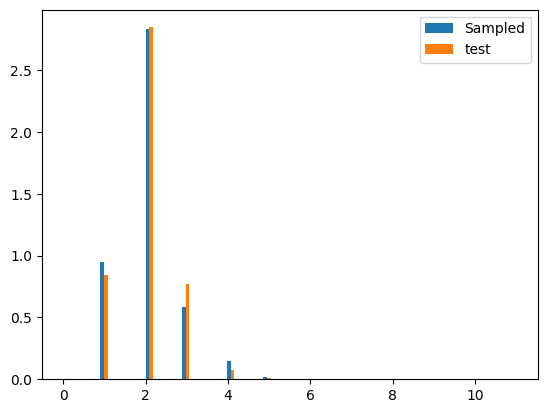

Variable: HousehNumcars
TtestResult(statistic=11.98041340908747, pvalue=4.791034024139236e-33, df=83446.0)


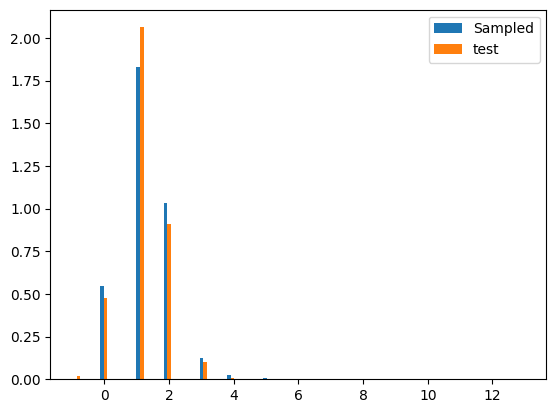

Variable: HousehNumPers
TtestResult(statistic=4.706225435364405, pvalue=2.527495183278356e-06, df=83446.0)


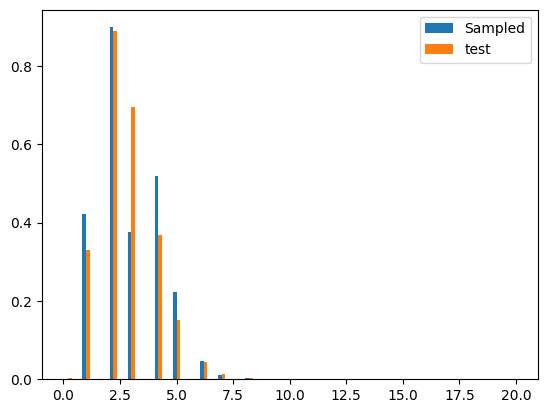

Variable: RespAgeCorrect
TtestResult(statistic=7.276761861550316, pvalue=3.4491966473482423e-13, df=83446.0)


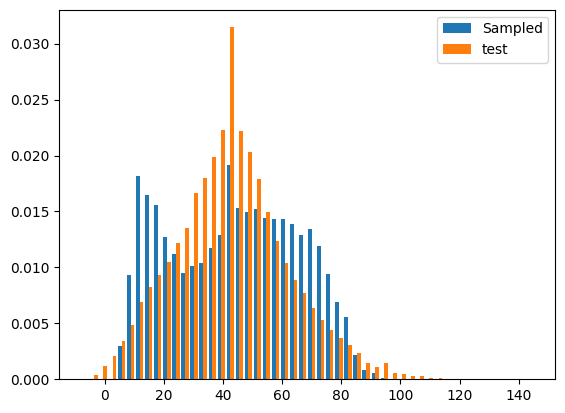

In [40]:
validationGAN.validate_Gan_num(test, round(wgan_n[numerical]))

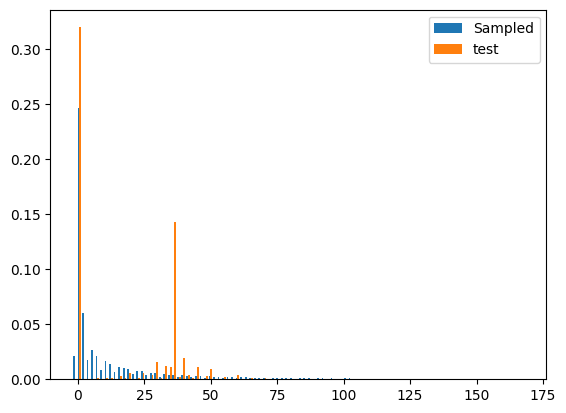

In [47]:
vect = wgan_n['WorkHoursPw'].loc[wgan_n['WorkHoursPw']<=168]
plt.hist([round(vect), train['WorkHoursPw']], 100,label=['Sampled', 'test'], density=True)
plt.legend(loc='upper right')
plt.show()

In [49]:
len(wgan_n['WorkHoursPw'].loc[wgan_n['WorkHoursPw']>168])

1491

In [42]:
round(train['WorkHoursPw']).mean()

16.793176362429133

Aggregated variables: 
MunicipalityOrigin
Number of combinations: 99
corr = 0.885350
MAE = 0.004939
RMSE = 0.010249
SRMSE = 1.004355
r2 = 0.059255


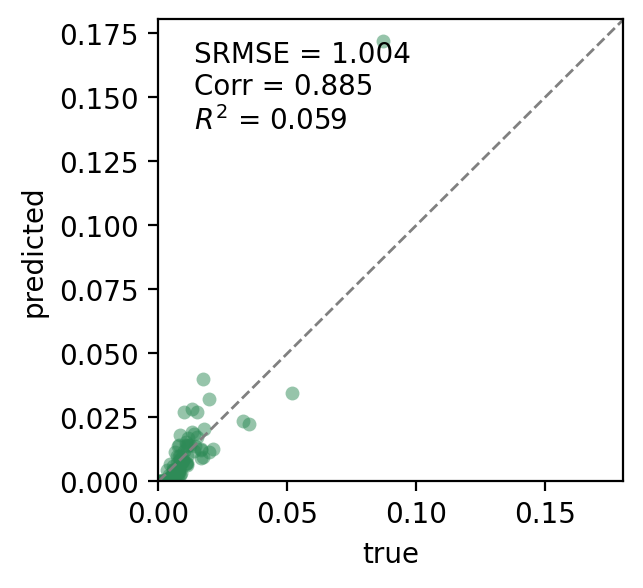

count_real  count_sampled      diff
MunicipalityOrigin                                     
101                   0.087120       0.171700 -0.084580
147                   0.016369       0.012583  0.003787
151                   0.007669       0.005129  0.002541
153                   0.004865       0.001510  0.003355
155                   0.002373       0.000120  0.002253
157                   0.009299       0.007645  0.001654
159                   0.013733       0.018503 -0.004769
161                   0.003283       0.004362 -0.001079
163                   0.004362       0.000288  0.004074
165                   0.003907       0.000336  0.003571
167                   0.007909       0.004434  0.003475
169                   0.008221       0.002612  0.005608
173                   0.007933       0.003859  0.004074
175                   0.006519       0.003811  0.002708
183                   0.003188       0.000264  0.002924
185                   0.006255       0.000791  0.005464
187                   0.002325       0.000503  0.001821
190                   0.006183       0.002588  0.003595
201                   0.004218       0.000551  0.003667
210                   0.006255       0.001366  0.004889
217                   0.009779       0.011816 -0.002037
219                   0.008508       0.008532 -0.000024
223                   0.003595       0.000096  0.003499
230                   0.007813       0.009874 -0.002061
240                   0.007190       0.003907  0.003283
250                   0.008269       0.017951 -0.009683
253                   0.007981       0.003835  0.004146
259                   0.010641       0.007238  0.003403
260                   0.005656       0.006160 -0.000503
265                   0.019437       0.032092 -0.012655
269                   0.003451       0.000671  0.002780
270                   0.007094       0.001893  0.005201
306                   0.006327       0.004002  0.002325
316                   0.013038       0.028449 -0.015411
320                   0.006495       0.011552 -0.005057
326                   0.009060       0.009419 -0.000360
329                   0.005896       0.002109  0.003787
330                   0.013757       0.011720  0.002037
336                   0.004266       0.002349  0.001917
340                   0.005584       0.004434  0.001150
350                   0.005153       0.002277  0.002876
360                   0.007885       0.014117 -0.006231
370                   0.014931       0.026987 -0.012055
376                   0.011121       0.006591  0.004530
390                   0.008724       0.003260  0.005464
400                   0.007430       0.013853 -0.006423
410                   0.007262       0.005656  0.001606
420                   0.008317       0.008628 -0.000312
430                   0.009803       0.027083 -0.017280
440                   0.004410       0.001798  0.002612
450                   0.005968       0.004626  0.001342
461                   0.032787       0.023512  0.009275
479                   0.011552       0.014093 -0.002541
480                   0.005800       0.004290  0.001510
482                   0.002564       0.000527  0.002037
492                   0.001150       0.000000  0.001150
510                   0.010761       0.014093 -0.003331
530                   0.005177       0.000815  0.004362
540                   0.014212       0.013805  0.000407
550                   0.007693       0.001510  0.006183
561                   0.021067       0.012774  0.008293
563                   0.000479       0.000000  0.000479
573                   0.010569       0.015219 -0.004650
575                   0.008604       0.007334  0.001270
580                   0.011049       0.013877 -0.002828
607                   0.009107       0.007813  0.001294
615                   0.015027       0.017208 -0.002181
621                   0.016465       0.012223  0.004242
630                   0.019701       0.011480  0.008221
657                   0.016633       0.00901

In [53]:
validationGAN.evaluate(test, wgan_n, ['MunicipalityOrigin'], train)

In [ ]:
from Utils import saveUtils
saveUtils.saveGenerator(_Wgan)

In [ ]:
from tensorflow.keras.models import load_model

def saveGenerator(generator_path, _WGAN):
    generator = _WGAN.generator
    generator_path = generator_path
    generator.save(generator_path)

def sampleGen(loaded_generator, n_samples, wgan_latent_dim, numerical_col_n,categories_cum, samp_df, col_names, pre_one_hot_df):
    z_sample = np.random.normal(0., 1.0, size=(n_samples, wgan_latent_dim))
    prediction = loaded_generator.predict(z_sample).transpose()

    samples = np.zeros((validation.shape[1], n_samples))
    samples[:numerical_col_n,:]=prediction[:numerical_col_n,:]
    for idx in range(len(categories_cum)-1):
        idx_i = numerical_col_n+categories_cum[idx] # Initial index
        idx_f = numerical_col_n+categories_cum[idx+1] # Final index
        mask = np.argmax(prediction[idx_i:idx_f, :], axis=0) + idx_i
        samples[mask, np.arange(len(mask))] = 1

    wgan_n  = tuUtils.samples_to_df(samples, print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)
    return wgan_n


In [1]:
print('hello')

hello


In [ ]:
generator_path = 'generator_model_v1.h5'
saveGenerator(generator_path, _WGAN)
loaded_generator = tf.keras.models.load_model(generator_path)
gen_samp = sampleGen(loaded_generator, 10000, wgan_latent_dim, numerical_col_n, categories_cum, samp_df, col_names, pre_one_hot_df)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/.popsyn/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 2s 6ms/step


NameError: name 'saveGenerator' is not defined

In [ ]:
_WGAN.n_samples = len(test)
wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)
wgan_n.head()

938/938 [==============================] - 3s 3ms/step


HousehCarOwnership  Year Gender Education Handicap PopSocio RespPrimOcc  \
0                1.0  2010      1       H30      2.0        1       210.0   
1                1.0  2011      1       H30      2.0        1       210.0   
2                1.0  2019      2       H30      2.0        1       210.0   
3                1.0  2010      1       H30      2.0        3       370.0   
4                1.0  2011      2       H30      1.0        3       370.0   

  KidsBetween0and15 KidsBetween0and4 CarModelYear MunicipalityOrigin  \
0                 0                0       2016.0                101   
1                 0                0       2009.0                101   
2                 0                0       2009.0                851   
3                 0                0       2007.0                561   
4                 0                0         -1.0                561   

  MunicipalityDest HomeAdrZone PrimOccZone WorkHourType RespHasBicycle  \
0            101.0    103253.0    766062.0          1.0            1.0   
1            751.0       516.0    766062.0          1.0            1.0   
2          MISSING    510095.0    336024.0  Not working            1.0   
3          MISSING    482022.0    336024.0  Not working            2.0   
4          MISSING    810131.0    336024.0  Not working            1.0   

  ResphasDrivlic RespHasRejsekort RespIsmemCarshare  \
0            1.0              2.0               2.0   
1            1.0              2.0               2.0   
2            1.0              2.0               2.0   
3            1.0              2.0               2.0   
4            1.0              2.0               2.0   

                       Sector HwDayspW FuelType  IncFamily2000  \
0            Residential care      5.0      1.0       0.599457   
1  Wholesale and retail trade      5.0      1.0       1.103402   
2         Activity not stated      5.0      1.0      -0.277091   
3         Activity not stated      0.0      1.0      -0.204841   
4         Activity not stated      0.0      1.0      -0.918006   

   IncRespondent2000  WorkHoursPw  FamNumAdults  FamNumPers  HousehNumAdults  \
0           1.258393     1.408941      0.239104    0.316008        -0.518299   
1           1.328575     0.603968      0.225798    0.244721         0.043129   
2          -0.617224    -0.297005      1.011974    0.696584         1.236697   
3           1.348883     0.424883      0.412839   -0.544812         0.109689   
4           0.565881    -1.218291     -0.553582   -0.055414         0.016822   

   HousehNumcars  HousehNumPers  RespAgeCorrect  
0       0.096937       0.361591       -0.751044  
1       0.656082       0.551863       -0.169189  
2       0.316665       0.000051        0.705328  
3       0.941441      -0.808235        0.989995  
4      -0.370565      -0.576801        2.061011

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.0009677583500695811, MSE:4.7571748865432e-05, RMSE:0.0068972276216920664, SRSME:0.2745061933779351
corr = 0.695788
MAE = 0.001566
RMSE = 0.008773
SRMSE = 8.589018
r2 = -17.395007


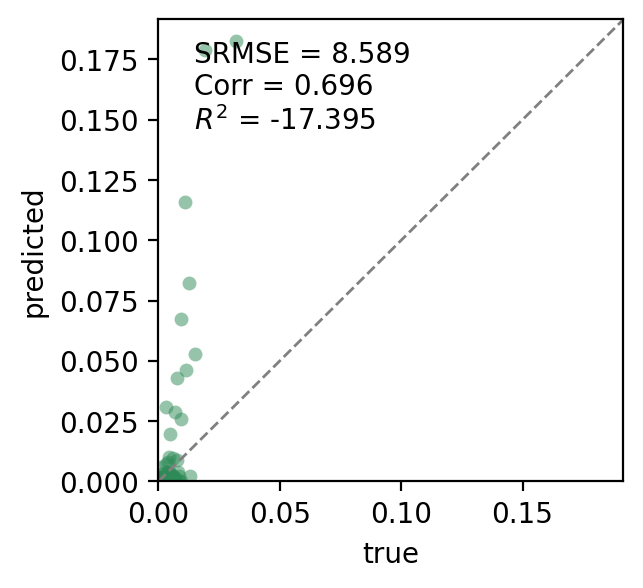

In [21]:
categorical = ['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.014622722610051653, MSE:0.002064932291430826, RMSE:0.04544152606846326, SRSME:0.4521374756107392
corr = 0.883445
MAE = 0.014772
RMSE = 0.045673
SRMSE = 4.475933
r2 = -17.341483


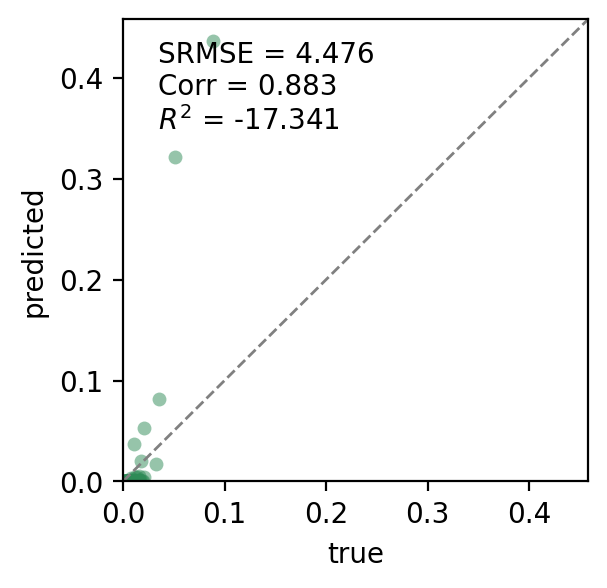

In [22]:
categorical = ['MunicipalityOrigin']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.009080756330399887, MSE:0.0002766351792161073, RMSE:0.016632353387783322, SRSME:0.09408679894074107
corr = 0.989089
MAE = 0.010762
RMSE = 0.018107
SRMSE = 0.488889
r2 = 0.957694


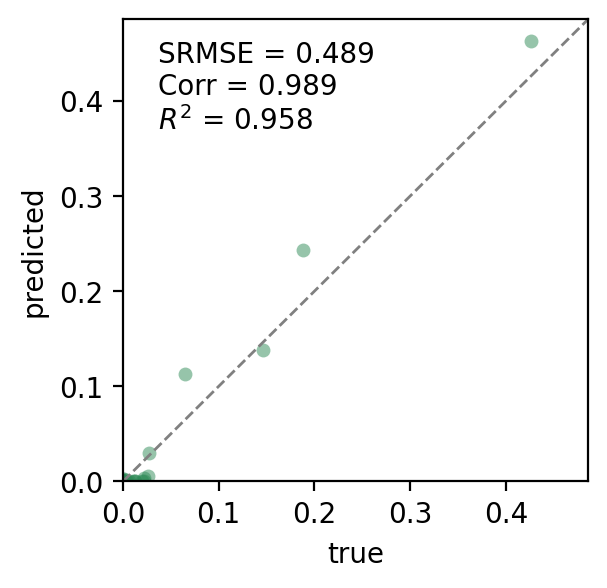

In [24]:
categorical = ['Handicap', 'ResphasDrivlic', 'PopSocio']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.05682649434264163, MSE:0.004998346047372161, RMSE:0.07069898194013943, SRSME:0.14139796388027887
corr = 0.997223
MAE = 0.056826
RMSE = 0.070699
SRMSE = 0.282796
r2 = 0.937575


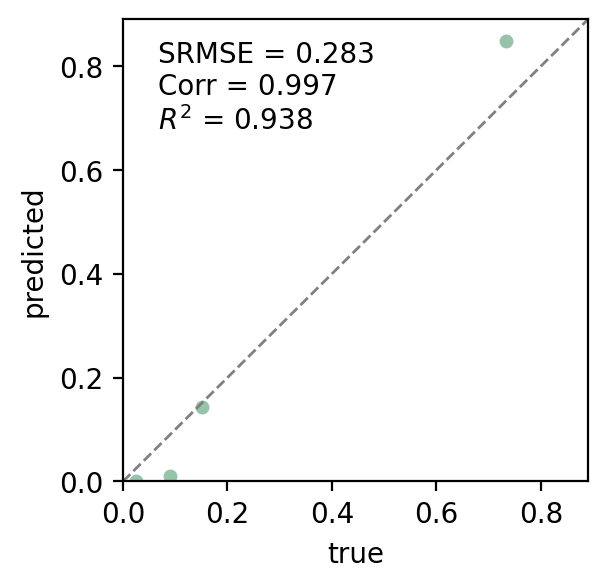

In [25]:
categorical = ['ResphasDrivlic']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.011507803128664878, MSE:0.0005701275662158865, RMSE:0.02387734420357269, SRSME:0.14524021464452536
corr = 0.986115
MAE = 0.011508
RMSE = 0.023877
SRMSE = 0.883462
r2 = 0.857664


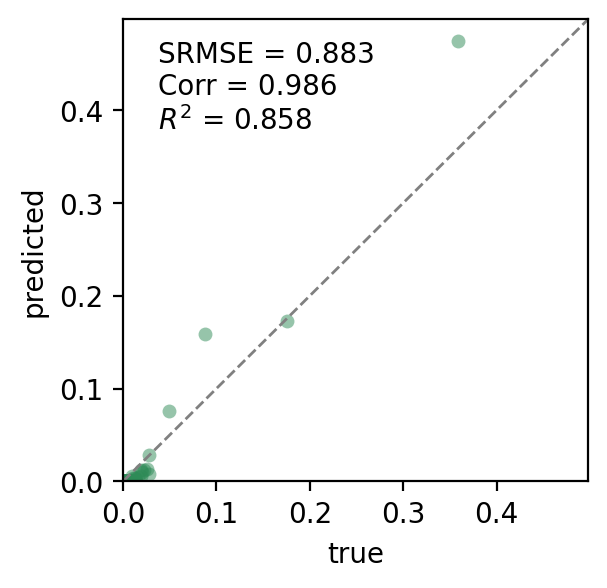

In [53]:
categorical = ['Sector']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.00043426471089239195, MSE:2.2962730414982723e-05, RMSE:0.004791944325113004, SRSME:0.29002151904657303
corr = 0.719155
MAE = 0.000664
RMSE = 0.005924
SRMSE = 14.199212
r2 = -25.387835


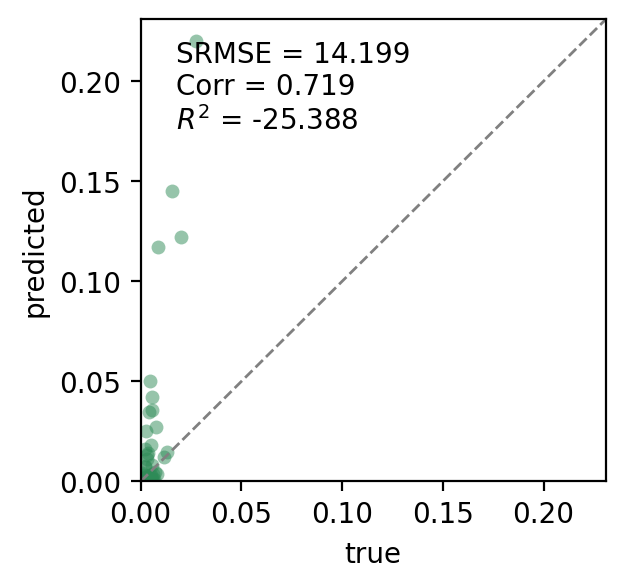

In [26]:
categorical = ['MunicipalityOrigin', 'Sector']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.00012532121088980398, MSE:2.1974749578098938e-06, RMSE:0.001482388261492209, SRSME:0.1474957697099071
corr = 0.670798
MAE = 0.000489
RMSE = 0.002929
SRMSE = 7.426233
r2 = -2.093328


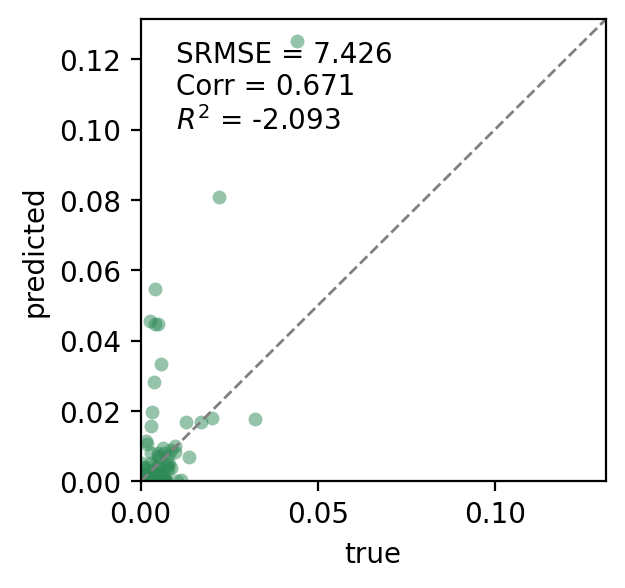

In [ ]:
categorical = ['MunicipalityOrigin', 'MunicipalityDest']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.012484067647021473, MSE:0.0004737464792764488, RMSE:0.02176571798210316, SRSME:0.10662980588294613
corr = 0.960468
MAE = 0.015769
RMSE = 0.024463
SRMSE = 0.464789
r2 = 0.919697


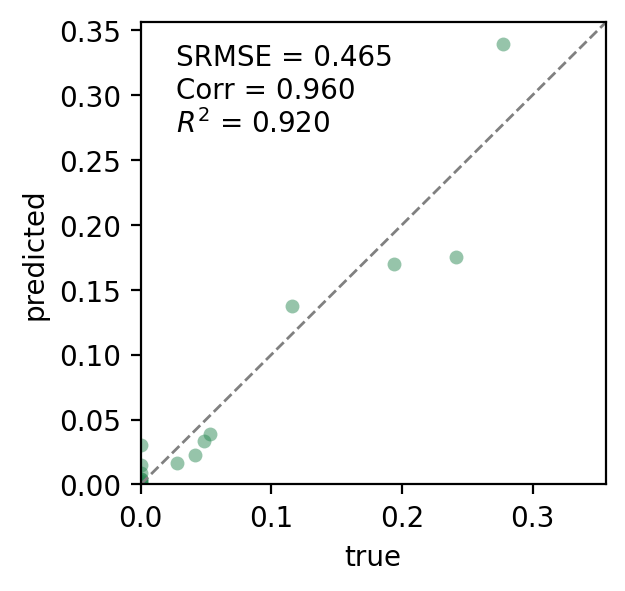

In [61]:
categorical = ['WorkHourType', 'PopSocio']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

/home/s212945/snap/snapd-desktop-integration/83/Documents/Thesis/MSc_PopSyn/Sigga_Luis/Utils/tuUtils.py:69: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_columns = dummy_df.idxmax(axis=1)


MAE:0.02857219932378233, MSE:0.0010895421625391358, RMSE:0.03300821356176574, SRSME:0.11901280650841221
corr = 0.799497
MAE = 0.028572
RMSE = 0.033008
SRMSE = 0.429107
r2 = -0.312410


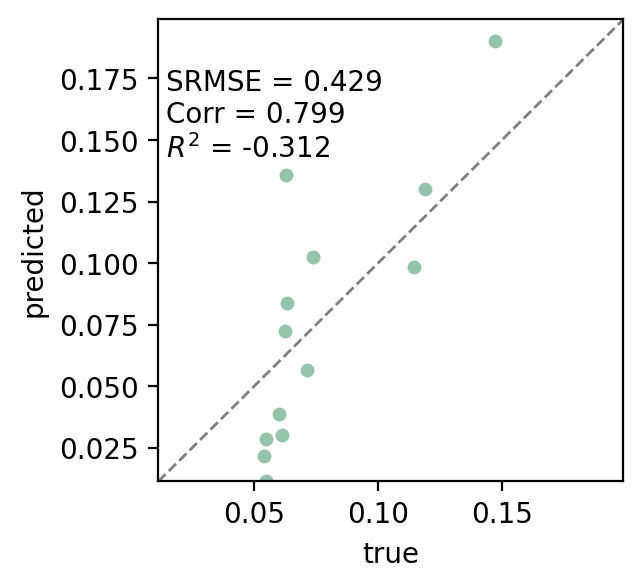

In [58]:
categorical = ['Year']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=train, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
categorical = ['Year']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=train, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
_WGAN_2 = WGAN(train=train, validation=validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=512, latent_dim=wgan_latent_dim, n_hidden_layers_gen=5, # Generator architecture 
             intermediate_dim_crit=512, n_hidden_layers_crit=5, # Critic architecture 
             batch_size=32, epochs=epochs_WGAN, gen_learn_rate=7.51986904e-04 ,
             crit_learn_rate=7.51986904e-04 , clip_value=0.01, nCritic=5) # drop_rate_g=0., drop_rate_c=0.25
_WGAN_2.wgan_evaluate()

/Users/siggahalldorsdottir/opt/anaconda3/envs/thesis/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 21ms/step
0 [D loss: 0.000506, acc.: 0.00%] [G loss: -0.001166]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step
100 [D loss: 0.000376, acc.: 0.00%] [G loss: -0.001049]
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 33ms/step
200 [D loss: 0.000376, acc.: 0.00%] [G loss: -0.001049]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step
300 [D loss: 0.000376, acc.: 0.00%] [G loss: -0.001049]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step
400 [D loss: 0.000376, acc.: 0.00%] [G loss: -0.001049]
1/1 [==============================] - 0s 40ms/step


KeyboardInterrupt: 

In [ ]:
plt.plot(range(epochs_WGAN), _WGAN.gen_loss, 'k', range(epochs_WGAN), _WGAN.crit_loss);

In [ ]:
categorical = ['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=_WGAN_2, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
categorical = ['MunicipalityOrigin', 'Sector']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=WGAN_2, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
categorical = ['MunicipalityOrigin', 'MunicipalityDest']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=WGAN_2, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
def run_wgan(train=train, validation=validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum,
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=256, latent_dim=10, n_hidden_layers_gen=4,
             intermediate_dim_crit=256, n_hidden_layers_crit=4,
             batch_size=100, epochs=2000, gen_learn_rate=0.0001, crit_learn_rate=0.0005,
             clip_value=0.01, nCritic=5):
    
    #categorical = ['MunicipalityOrigin', 'MunicipalityDest', 'GISdistHW'] # Change as needed
    
    _wgan = WGAN(train=train, validation=validation, numerical_col_n=numerical_col_n,
             categorical_col_n = categorical_col_n, categories_n = categories_n, 
             categories_cum = categories_cum, # Data
             eval_set=['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio'], 
             col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df,# Data
             intermediate_dim_gen=intermediate_dim_gen, latent_dim=latent_dim, n_hidden_layers_gen=5, # Generator architecture 
             intermediate_dim_crit=intermediate_dim_crit, n_hidden_layers_crit=n_hidden_layers_crit, # Critic architecture 
             batch_size=batch_size, epochs=epochs, gen_learn_rate=gen_learn_rate, 
             crit_learn_rate=crit_learn_rate, clip_value=clip_value, nCritic=nCritic)

    _wgan.n_samples  = 18688*5

    wgan_evaluation = _wgan.wgan_evaluate()
    return wgan_evaluation

In [ ]:
categorical = ['MunicipalityOrigin', 'ResphasDrivlic', 'PopSocio']# ['IncRespondent2000', 'ResphasDrivlic', 'RespAgeCorrect', 'PopSocio']  wgan50ndo
_ = validationUtils.evaluate(real=test, model=wgan_n, agg_vars=categorical, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df, n_samples=80000, plot=True)

In [ ]:
samples = []
for i in range(20):
    _WGAN.n_samples = 100000
    wgan_n  = tuUtils.samples_to_df(_WGAN.sampler(), print_duplicates=False, col_names=col_names, original_df=samp_df, pre_one_hot_df=pre_one_hot_df)
    samples.append(wgan_n)
    
df = pd.concat(samples, ignore_index=True)
df.to_csv('wgan_samples.txt', sep=',', index=False)

3125/3125 [==============================] - 25s 8ms/step


# 

# Numerical

In [64]:
numerical_columns = wgan_n[numerical].columns

# Perform the inverse transform
inverse_transformed_data = scaler.inverse_transform(wgan_n[numerical])

# Create a new DataFrame with the inverse-transformed data and the original column names
result_df = pd.DataFrame(inverse_transformed_data, columns=numerical_columns)

In [66]:
result_df.head()

IncFamily2000  IncRespondent2000  WorkHoursPw  FamNumAdults  FamNumPers  \
0    9450.000760       -9898.434665   -30.527741      2.805595    3.606887   
1   -7561.317603       -2550.470584    -1.331697     -0.063508    4.571865   
2   -5006.651217       -3932.100165     7.650151      2.378472    2.863095   
3    1479.456969       -3985.167902    29.197865      2.118088    4.477910   
4   -9848.327997       -3371.528961    49.011559      1.344732    3.091112   

   HousehCarOwnership  HousehNumAdults  HousehNumcars  HousehNumPers  \
0           -1.208298         2.288647      -1.202128       7.522758   
1           -2.465080        -0.661412      -2.453802       3.075618   
2            0.816038         1.447566      -2.152614       1.613910   
3            3.387194         0.510584       7.094318      -0.499692   
4            2.955438         0.238458       5.507041      -0.784081   

   RespAgeCorrect  KidsBetween0and15  KidsBetween0and4  
0       24.643642           2.129291         -0.695063  
1       46.069835          -1.099112          0.140705  
2       30.183061          -0.058950          0.772108  
3       23.518282           0.634680         -0.071120  
4       31.204725           0.714123          0.560588

In [83]:
samp_df.head()

HousehNumAdults WorkHoursPw  FamNumAdults  FamNumPers  HousehNumPers  \
0              2.0         0.0           2.0         8.0            8.0   
1              1.0         0.0           1.0         3.0            3.0   
2              2.0         0.0           2.0         4.0            4.0   
3              2.0         0.0           2.0         4.0            4.0   
4              2.0         0.0           2.0         3.0            3.0   

   HousehCarOwnership  IncRespondent2000  IncFamily2000  HousehNumcars  Year  \
0                 1.0                0.0         1107.0            1.0  2009   
1                 0.0                0.0          487.0            0.0  2009   
2                 0.0              424.0          424.0            1.0  2009   
3                 2.0                0.0            0.0            2.0  2009   
4                 1.0                0.0          509.0            1.0  2009   

  Gender  RespAgeCorrect Education Handicap PopSocio RespPrimOcc  \
0      2            15.0       H10      2.0        0       107.0   
1      1            14.0       H10      2.0        0       116.0   
2      1            14.0       H10      2.0        3       390.0   
3      2            10.0       H10      2.0        0       107.0   
4      2            12.0       H10      2.0        0       107.0   

   KidsBetween0and15  KidsBetween0and4  CarModelYear MunicipalityOrigin  \
0                  5                 1        2001.0                101   
1                  1                 0          -1.0                101   
2                  1                 0        2005.0                846   
3                  1                 0        2003.0                630   
4                  0                 0        2007.0                791   

  MunicipalityDest HomeAdrZone PrimOccZone WorkHourType RespHasBicycle  \
0            101.0       572.0       592.0  Not working            2.0   
1            101.0       187.0       191.0  Not working            2.0   
2          MISSING    846212.0     MISSING  Not working            1.0   
3            630.0    630342.0    630342.0  Not working            1.0   
4            791.0    791355.0    791354.0  Not working            1.0   

  ResphasDrivlic RespHasRejsekort RespIsmemCarshare               Sector  \
0          -18.0             30.0               2.0            Education   
1          -18.0              1.0               2.0            Education   
2          -18.0             10.0               1.0  Activity not stated   
3          -18.0             20.0               2.0            Education   
4          -18.0              6.0               2.0            Education   

   HwDayspW FuelType  
0       5.0      1.0  
1       5.0    NoCar  
2       0.0      1.0  
3       5.0      1.0  
4       5.0      2.0

In [39]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, Normalizer
scaler = MinMaxScaler()

In [14]:
samp_df[numerical].head()

IncFamily2000  IncRespondent2000 WorkHoursPw  FamNumAdults  FamNumPers  \
0         1107.0                0.0         0.0           2.0         8.0   
1          487.0                0.0         0.0           1.0         3.0   
2          424.0              424.0         0.0           2.0         4.0   
3            0.0                0.0         0.0           2.0         4.0   
4          509.0                0.0         0.0           2.0         3.0   

   HousehNumAdults  HousehNumcars  HousehNumPers  RespAgeCorrect  \
0              2.0            1.0            8.0            15.0   
1              1.0            0.0            3.0            14.0   
2              2.0            1.0            4.0            14.0   
3              2.0            2.0            4.0            10.0   
4              2.0            1.0            3.0            12.0   

   KidsBetween0and15  KidsBetween0and4  
0                  5                 1  
1                  1                 0  
2                  1                 0  
3                  1                 0  
4                  0                 0

In [40]:
income_col = numerical
numerical_columns = samp_df[income_col].columns

# Perform the inverse transform
transformed_data = scaler.fit_transform(samp_df[income_col])

# Create a new DataFrame with the inverse-transformed data and the original column names
result_df = pd.DataFrame(transformed_data, columns=numerical_columns)
result_df.head()

IncFamily2000  IncRespondent2000  WorkHoursPw  FamNumAdults  FamNumPers  \
0       0.026766           0.000000          0.0      0.181818    0.500000   
1       0.011775           0.000000          0.0      0.090909    0.142857   
2       0.010252           0.006002          0.0      0.181818    0.214286   
3       0.000000           0.000000          0.0      0.181818    0.214286   
4       0.012307           0.000000          0.0      0.181818    0.142857   

   HousehNumAdults  HousehNumcars  HousehNumPers  RespAgeCorrect  \
0         0.181818           0.04       0.179487        0.098039   
1         0.090909           0.00       0.051282        0.088235   
2         0.181818           0.04       0.076923        0.088235   
3         0.181818           0.08       0.076923        0.049020   
4         0.181818           0.04       0.051282        0.068627   

   KidsBetween0and15  HousehCarOwnership  KidsBetween0and4  
0              0.625                0.05          0.333333  
1              0.125                0.00          0.000000  
2              0.125                0.00          0.000000  
3              0.125                0.10          0.000000  
4              0.000                0.05          0.000000

In [20]:
numerical_columns = wgan_n[numerical].columns

# Perform the inverse transform
inverse_transformed_data = scaler.inverse_transform(wgan_n[numerical])

# Create a new DataFrame with the inverse-transformed data and the original column names
result_df = pd.DataFrame(inverse_transformed_data, columns=numerical_columns)
result_df.head()

IncFamily2000  IncRespondent2000  WorkHoursPw  FamNumAdults  FamNumPers  \
0     528.331870         427.864704    82.903582      2.061434    2.915982   
1     729.987019         449.834339    11.360563      2.051775    2.815741   
2     260.952086          59.554373     1.463250      2.672714    3.497366   
3     279.129525         456.313000     7.659000      2.190123    1.863077   
4     128.580591         244.799738    -0.345316      1.532238    2.421066   

   HousehNumAdults  HousehNumcars  HousehNumPers  RespAgeCorrect  
0         1.584304       1.237806       3.032390       26.902218  
1         1.953188       1.724322       3.318144       38.920110  
2         2.912963       1.422306       2.539909       58.807475  
3         2.000139       1.994492       1.643514       65.692305  
4         1.934827       0.873443       1.874344       93.166115

<Axes: ylabel='Frequency'>

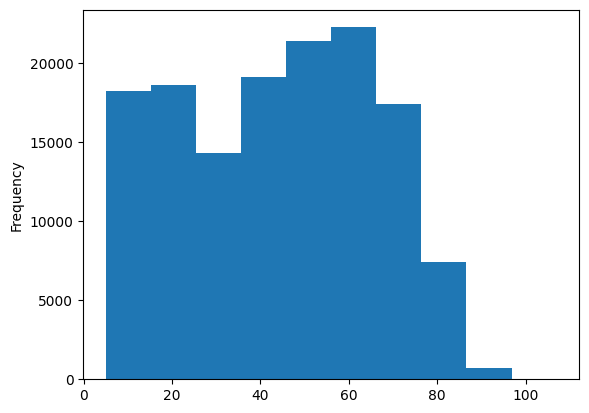

In [ ]:
samp_df['RespAgeCorrect'].plot(kind='hist')

In [31]:
generator_path = 'generator_model.h5'
loaded_generator = tf.keras.models.load_model(generator_path)
gen_samp = sampleGen(loaded_generator, 10000, 100, numerical_col_n, categories_cum, samp_df, col_names, pre_one_hot_df)

313/313 [==============================] - 1s 2ms/step


In [33]:
gen_samp.head()

Year Gender Education Handicap PopSocio RespPrimOcc CarModelYear  \
0  2021      1       H60      2.0        3       370.0       2014.0   
1  2020      2       H20      2.0        0       120.0         -1.0   
2  2020      2       H30      2.0        1       221.0       2014.0   
3  2019      2       H60      2.0        3       370.0       2000.0   
4  2016      1       H30      2.0        1       210.0       2010.0   

  MunicipalityOrigin MunicipalityDest HomeAdrZone PrimOccZone WorkHourType  \
0                259          MISSING    479238.0     MISSING  Not working   
1                751            101.0    751126.0     MISSING  Not working   
2                561            561.0    561122.0    561142.0      MISSING   
3                101          MISSING    329042.0     MISSING  Not working   
4                101            101.0    461241.0      1098.0          2.0   

  RespHasBicycle ResphasDrivlic RespHasRejsekort RespIsmemCarshare  \
0            2.0            1.0              2.0               2.0   
1            1.0            1.0             30.0               2.0   
2            1.0            1.0              2.0               2.0   
3            1.0            1.0              1.0               2.0   
4            1.0            1.0              1.0               2.0   

                Sector HwDayspW FuelType  IncFamily2000  IncRespondent2000  \
0  Activity not stated      0.0      2.0      -0.100696          -0.035295   
1  Activity not stated      3.0    NoCar      -0.108551          -0.257312   
2            Education      5.0      2.0       0.050720           0.688241   
3  Activity not stated      0.0      1.0      -0.178289           0.094448   
4            Education      5.0      1.0      -0.108804          -0.251479   

   WorkHoursPw  FamNumAdults  FamNumPers  HousehNumAdults  HousehNumcars  \
0     0.247323      0.007802   -0.086457         0.340651      -0.007365   
1    -0.263318      0.577389    0.301952         0.289372       0.360472   
2     0.322441      0.190465    0.175986         0.112474      -0.119567   
3    -0.008361      0.018750    0.555554        -0.067353       0.180445   
4     0.148762      0.486680    0.371573         0.167945       0.427265   

   HousehNumPers  RespAgeCorrect  KidsBetween0and15  HousehCarOwnership  \
0       0.210803       -0.141423           0.098022            0.108023   
1      -0.523619       -0.066813           0.094731           -0.381875   
2       0.034433        0.045034           0.327785           -0.075862   
3       0.364027        0.021957           0.803654            0.018537   
4      -0.068494       -0.037999           0.166599            0.376504   

   KidsBetween0and4  
0          0.036179  
1         -0.275344  
2          0.225068  
3          0.101126  
4          0.055636

In [41]:
income_col = numerical
numerical_columns = gen_samp[income_col].columns

# Perform the inverse transform
transformed_data = scaler.inverse_transform(gen_samp[income_col])

# Create a new DataFrame with the inverse-transformed data and the original column names
result_df = pd.DataFrame(transformed_data, columns=numerical_columns)
result_df.head()

IncFamily2000  IncRespondent2000  WorkHoursPw  FamNumAdults  FamNumPers  \
0   -4164.581058       -2493.210269    41.550195      0.085821   -0.210400   
1   -4489.460703      -18176.502824   -44.237354      6.351284    5.227331   
2    2097.682640       48617.340379    54.170005      2.095118    3.463807   
3   -7373.684317        6671.786734    -1.404656      0.206255    8.777761   
4   -4499.910693      -17764.442866    24.991949      5.353477    6.202018   

   HousehNumAdults  HousehNumcars  HousehNumPers  RespAgeCorrect  \
0         3.747157      -0.184114       9.221300       -9.425167   
1         3.183090       9.011811     -19.421159       -1.814925   
2         1.237212      -2.989170       2.342884        9.593507   
3        -0.740879       4.511130      15.197038        7.239618   
4         1.847393      10.681637      -1.671255        1.124085   

   KidsBetween0and15  HousehCarOwnership  KidsBetween0and4  
0           0.784176            2.160463          0.108536  
1           0.757852           -7.637497         -0.826032  
2           2.622281           -1.517234          0.675203  
3           6.429232            0.370741          0.303379  
4           1.332789            7.530085          0.166908